In [18]:
# Part 0: Setup and Global Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import glob
import os
import time # For timing epochs
from sklearn.metrics import accuracy_score 
# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Define global constants based on recommendations ---
DATA_PATH = "data/"
SEQUENCE_LENGTH = 500
ENCODING_DIM_AE = 64

# --- Autoencoder Specific Training Parameters ---
AE_TRAIN_EPOCHS_FINAL = 150  # ◊ê◊§◊©◊® ◊ú◊î◊™◊ê◊ô◊ù
AE_PATIENCE_FINAL = 20       # ◊î◊ï◊®◊ì◊†◊ï ◊û◊¢◊ò ◊ê◊™ ◊î◊°◊ë◊ú◊†◊ï◊™, ◊ú◊î◊™◊ê◊ô◊ù ◊ú◊§◊ô ◊î◊¶◊ï◊®◊ö
AE_BATCH_SIZE = 32
AE_LEARNING_RATE = 1e-3
AE_WEIGHT_DECAY = 5e-5     # ◊î◊¢◊ú◊ô◊†◊ï ◊û◊¢◊ò ◊ê◊™ ◊î-weight decay
AE_DROPOUT_RATE = 0.3      # ◊î◊¢◊ú◊ô◊†◊ï ◊û◊¢◊ò ◊ê◊™ ◊î-dropout rate
AE_INPUT_NOISE_STD = 0.05  # ◊°◊ò◊ô◊ô◊™ ◊™◊ß◊ü ◊ú◊®◊¢◊© ◊©◊†◊ï◊°◊ô◊£ ◊ú◊ß◊ú◊ò ◊î-AE, 0 ◊õ◊ì◊ô ◊ú◊ë◊ò◊ú
AE_PLOT_RECONSTRUCTION_EPOCHS = 25 # ◊õ◊ú ◊õ◊û◊î ◊ê◊§◊ï◊ß◊ô◊ù ◊ú◊î◊¶◊ô◊í ◊í◊®◊£ ◊©◊ó◊ñ◊ï◊®◊ô◊ù

# Classifier training parameters
CLASSIFIER_TRAIN_EPOCHS = 100
CLASSIFIER_BATCH_SIZE = 32
AE_BATCH_SIZE = 32        # Adjusted for potentially larger models

# Fine-tuning stages epochs (can be adjusted)
FT_P1_EPOCHS = 200 # Head only
FT_P2_EPOCHS = 100  # Encoder FC layer + Head
FT_P3_EPOCHS = 120  # Encoder last conv block + FC + Head
FT_P4_EPOCHS = 120  # Encoder last 2 conv blocks + FC + Head
FT_P5_EPOCHS = 200 # Full encoder + Head
FT_PATIENCE = 20 # Patience for each fine-tuning phase

FT_P1_LR = 1e-4  
FT_P2_LR = 5e-6
FT_P3_LR = 1e-5
FT_P4_LR = 8e-6
FT_P5_LR = 5e-6

FT_P1_PATIENCE = 30
FT_P2_PATIENCE = 50
FT_P3_PATIENCE = 50
FT_P4_PATIENCE = 50
FT_P5_PATIENCE = 30
# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# --- Part 1: Data Loading and Preparation ---
print("--- Part 1: Data Loading and Preparation ---")
# (Assuming load_and_prepare_data and create_sequences functions are defined as in your previous code)
def load_and_prepare_data(data_path_folder):
    file_mapping = {
        'car_nothing(AVI).csv': 'quiet',
        'carnew(AVI).csv': 'vehicle',
        'human_nothing(AVI).csv': 'quiet',
        'human(AVI).csv': 'human'
    }
    label_encoding = {'quiet': 0, 'vehicle': 1, 'human': 2}
    all_data = []
    all_labels = []
    print("Starting data loading...")
    if not os.path.exists(data_path_folder):
        print(f"Data folder {data_path_folder} not found. Please create it and add data files.")
        return np.array([]), np.array([])
    for filename, activity_type in file_mapping.items():
        filepath = os.path.join(data_path_folder, filename)
        if not os.path.exists(filepath):
            print(f"Error: File not found at {filepath}. Skipping.")
            continue
        try:
            df = pd.read_csv(filepath, header=None)
            if not df.empty and df.shape[1] > 0:
                data = df.iloc[:, 0].values
                label_code = label_encoding[activity_type]
                all_data.extend(data)
                all_labels.extend([label_code] * len(data))
            else:
                print(f"Warning: File {filename} is empty or has no data columns. Skipping.")
        except Exception as e:
            print(f"Error reading {filename}: {e}")
    all_data_np = np.array(all_data)
    all_labels_np = np.array(all_labels)
    if len(all_data_np) > 0:
        print(f"Total data points loaded: {len(all_data_np)}")
    else:
        print("No data was loaded.")
    return all_data_np, all_labels_np

X_raw, y_raw = load_and_prepare_data(DATA_PATH)

if len(X_raw) == 0:
    print("No data loaded. Exiting.")
    exit()

def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_data = data[label_indices]
        num_sequences_for_label = len(label_data) // sequence_length
        for i in range(num_sequences_for_label):
            start_idx = i * sequence_length
            end_idx = start_idx + sequence_length
            sequences.append(label_data[start_idx:end_idx])
            sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

X_sequences, y_sequences = create_sequences(X_raw, y_raw, SEQUENCE_LENGTH)

if len(X_sequences) == 0:
    print("No sequences were created. Exiting.")
    exit()
print(f"Created {len(X_sequences)} sequences with length {SEQUENCE_LENGTH}.")

X_train_seq, X_temp_seq, y_train, y_temp = train_test_split(
    X_sequences, y_sequences, test_size=0.3, random_state=SEED, stratify=y_sequences
)
X_val_seq, X_test_seq, y_val, y_test = train_test_split(
    X_temp_seq, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

scaler = StandardScaler()
X_train_flat = X_train_seq.reshape(-1, 1); scaler.fit(X_train_flat)
X_train_normalized = scaler.transform(X_train_flat).reshape(X_train_seq.shape)
X_val_normalized = scaler.transform(X_val_seq.reshape(-1, 1)).reshape(X_val_seq.shape)
X_test_normalized = scaler.transform(X_test_seq.reshape(-1, 1)).reshape(X_test_seq.shape)

X_train_reshaped = X_train_normalized[:, np.newaxis, :]
X_val_reshaped = X_val_normalized[:, np.newaxis, :]
X_test_reshaped = X_test_normalized[:, np.newaxis, :]

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_reshaped, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_ae = TensorDataset(X_train_tensor, X_train_tensor)
val_dataset_ae = TensorDataset(X_val_tensor, X_val_tensor)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_ae = DataLoader(val_dataset_ae, batch_size=AE_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

train_dataset_clf = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset_clf = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset_clf = TensorDataset(X_test_tensor, y_test_tensor)
train_loader_clf = DataLoader(train_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader_clf = DataLoader(val_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader_clf = DataLoader(test_dataset_clf, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"DataLoaders created. Train AE: {len(train_loader_ae)} batches, Train CLF: {len(train_loader_clf)} batches.")


--- Part 1: Data Loading and Preparation ---
Starting data loading...
Total data points loaded: 3367075
Created 6733 sequences with length 500.
DataLoaders created. Train AE: 148 batches, Train CLF: 295 batches.



--- Part 3: Dilated Convolutional Autoencoder (Type A) - Enhanced Training ---


c:\Users\lidor\Desktop\◊§◊®◊ï◊ô◊ß◊ò ◊í◊ô◊ë◊ï◊ô\ProjectV4\torch_env_venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting Autoencoder (Type A) training with parameters:
  Epochs: 150, Patience: 20
  Batch Size: 32, LR: 1.0e-03, Weight Decay: 5.0e-05
  Dropout Rate: 0.3, Input Noise STD: 0.05, Encoding Dim: 64
AE Epoch 1/150 - 7.08s - Train Loss: 2.540962 - Val Loss: 0.652344 (Best: inf) - LR: 1.0e-03
  Val Loss improved from inf to 0.652344. Saving model.
AE Epoch 5/150 - 6.12s - Train Loss: 0.308094 - Val Loss: 0.203619 (Best: 0.247911) - LR: 1.0e-03
  Val Loss improved from 0.247911 to 0.203619. Saving model.
  Val Loss improved from 0.089620 to 0.056918. Saving model.
AE Epoch 10/150 - 6.12s - Train Loss: 0.128603 - Val Loss: 0.038698 (Best: 0.056918) - LR: 1.0e-03
  Val Loss improved from 0.056918 to 0.038698. Saving model.
  Val Loss improved from 0.038698 to 0.035440. Saving model.
AE Epoch 15/150 - 6.05s - Train Loss: 0.064376 - Val Loss: 0.057674 (Best: 0.035440) - LR: 1.0e-03
  Val Loss improved from 0.035440 to 0.033254. Saving model.
  Val Loss improved from 0.033254 to 0.029707. Savi

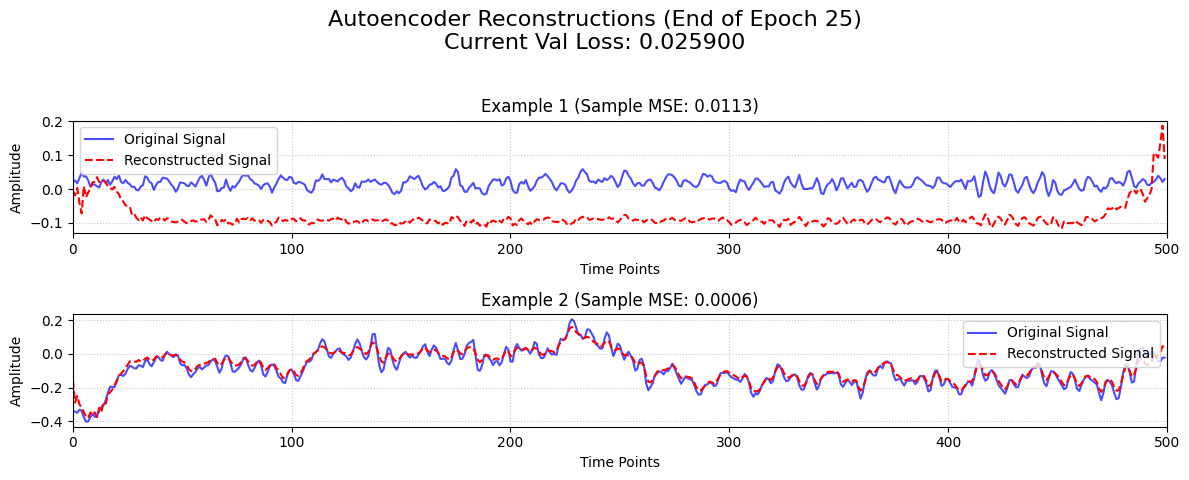

  Val Loss improved from 0.021680 to 0.018618. Saving model.
  Val Loss improved from 0.014420 to 0.014196. Saving model.
AE Epoch 30/150 - 6.05s - Train Loss: 0.035112 - Val Loss: 0.045150 (Best: 0.014196) - LR: 1.0e-03
AE Epoch 35/150 - 6.29s - Train Loss: 0.030646 - Val Loss: 0.010991 (Best: 0.014196) - LR: 1.0e-03
  Val Loss improved from 0.014196 to 0.010991. Saving model.
AE Epoch 40/150 - 6.24s - Train Loss: 0.027219 - Val Loss: 0.020916 (Best: 0.010991) - LR: 1.0e-03
AE Epoch 45/150 - 6.63s - Train Loss: 0.025143 - Val Loss: 0.025522 (Best: 0.010991) - LR: 1.0e-03
  Learning rate reduced to 2.0e-04 at epoch 46.
  Plotting 2 reconstruction examples...


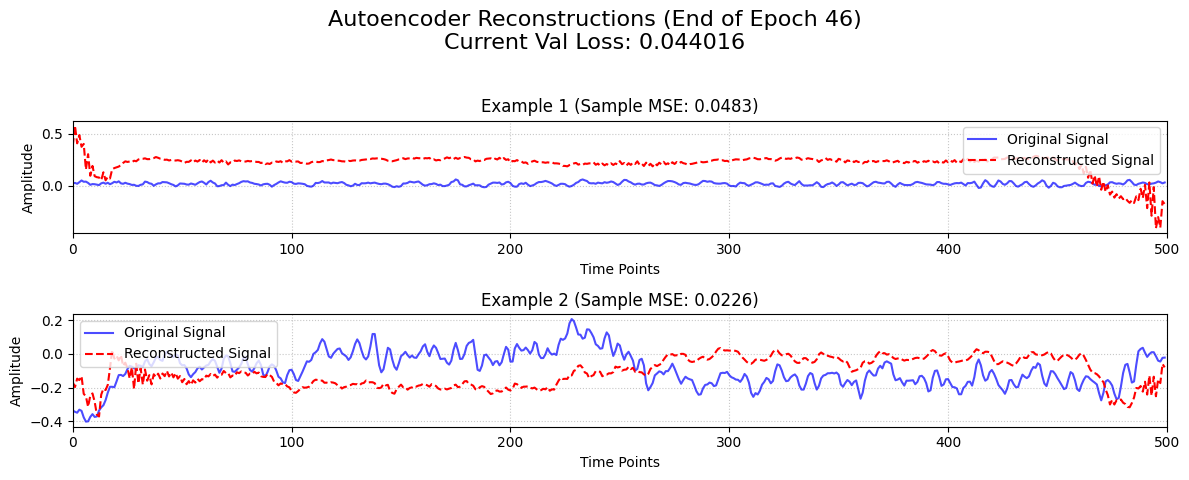

AE Epoch 50/150 - 6.56s - Train Loss: 0.018780 - Val Loss: 0.019863 (Best: 0.010991) - LR: 2.0e-04
  Plotting 2 reconstruction examples...


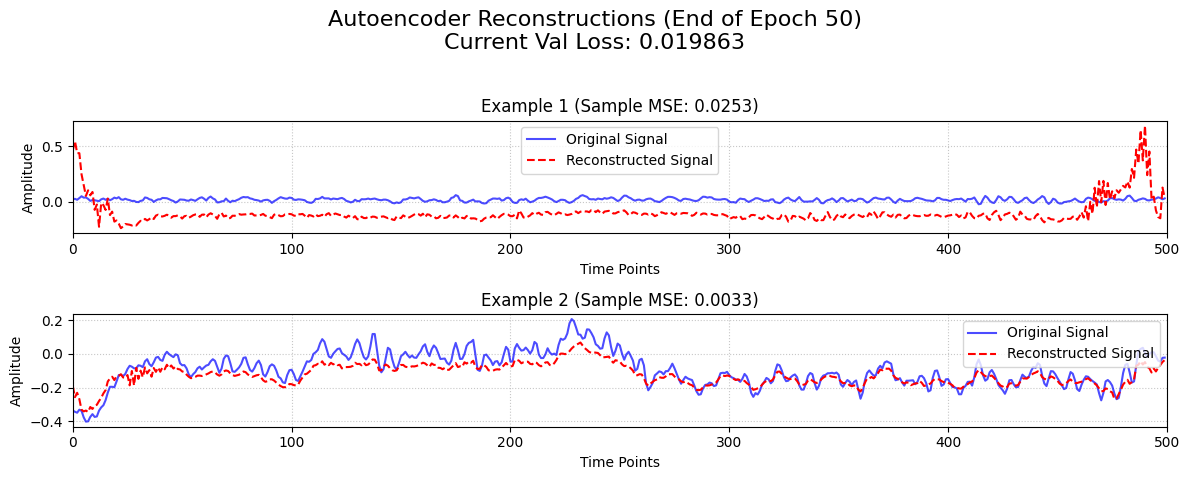

AE Epoch 55/150 - 6.32s - Train Loss: 0.018819 - Val Loss: 0.022193 (Best: 0.010991) - LR: 2.0e-04
  AE Early stopping at epoch 55. Best Val Loss: 0.010991

--- Autoencoder (Type A) training finished ---
Best AE Validation Loss achieved: 0.010991
Successfully loaded the best Autoencoder model.


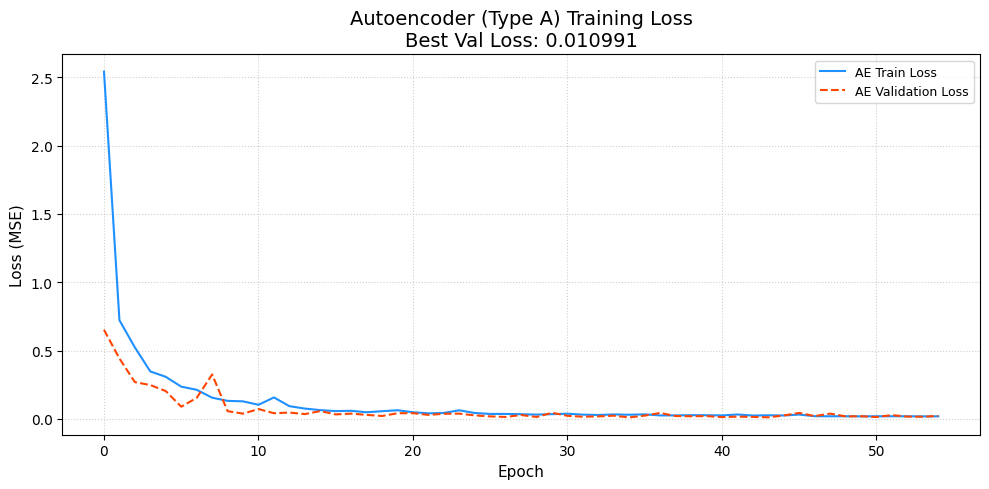

AE Loss history plot displayed.

Displaying final reconstructions from the best AE model...
  Plotting 3 reconstruction examples...


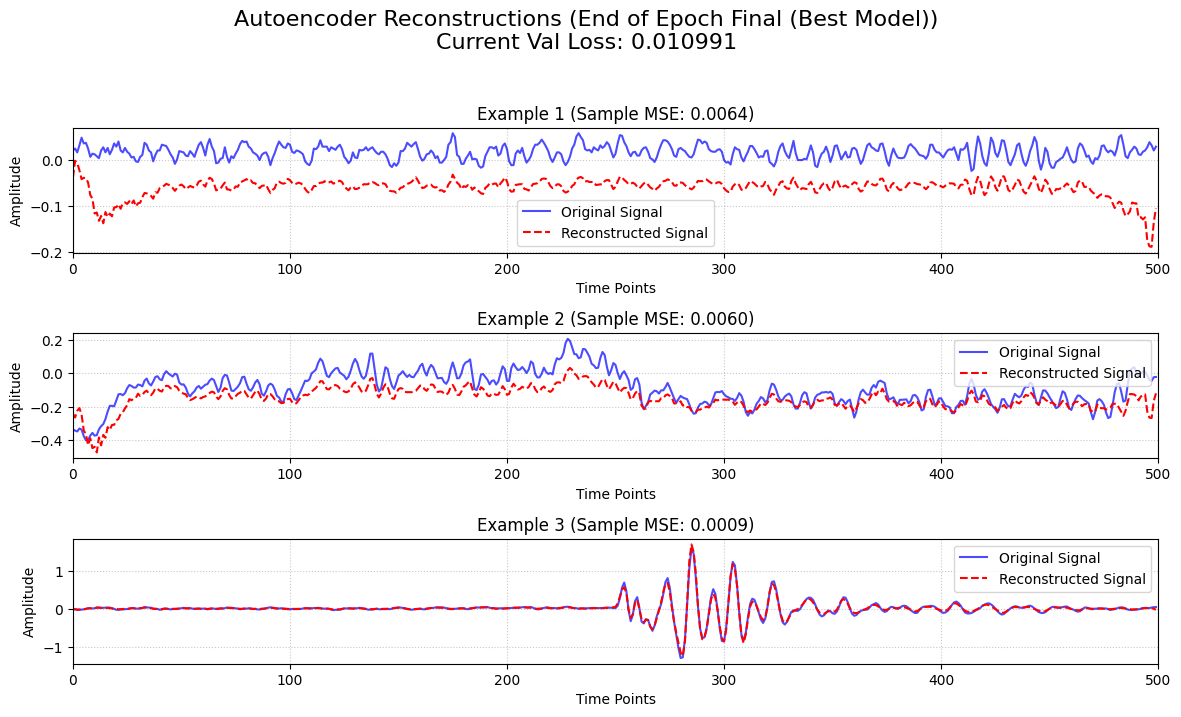

In [4]:
# --- Part 3: Dilated Convolutional Autoencoder with Skip Connections (Type A) - Enhanced ---
print("\n--- Part 3: Dilated Convolutional Autoencoder (Type A) - Enhanced Training ---")

# Helper for padding calculation
def get_padding_for_dilation(kernel_size, dilation):
    return (kernel_size - 1) * dilation // 2

# Function to add noise to input (for Denoising Autoencoder)
def add_noise_to_batch(batch_x, noise_std, device, is_training):
    if noise_std > 0 and is_training: # Add noise only during training
        noise = torch.randn_like(batch_x) * noise_std
        return batch_x + noise.to(device)
    return batch_x

# Function to plot AE reconstructions
def plot_ae_reconstructions(model, dataloader, device, num_samples=3, epoch_num=None, current_loss=None, sequence_length=SEQUENCE_LENGTH, plot_now=True):
    # This function can generate many plots. Consider saving to file instead of showing all.
    if not plot_now:
        return
        
    print(f"  Plotting {num_samples} reconstruction examples...")
    model.eval() # Ensure model is in eval mode for plotting
    samples_done = 0
    
    fig_height = 2.5 * num_samples
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, fig_height), squeeze=False)

    with torch.no_grad():
        for batch_x_val, _ in dataloader: # Using val_loader_ae for examples
            batch_x_val_original = batch_x_val.clone().to(device)
            reconstructed_x_val = model(batch_x_val_original) # Reconstruct from original (clean) input

            for i in range(batch_x_val_original.size(0)):
                if samples_done < num_samples:
                    original_signal = batch_x_val_original[i].cpu().squeeze().numpy()
                    reconstructed_signal = reconstructed_x_val[i].cpu().squeeze().numpy()

                    ax = axes[samples_done, 0]
                    ax.plot(original_signal, label='Original Signal', color='blue', alpha=0.7)
                    ax.plot(reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='--')
                    
                    mse_sample = np.mean((original_signal - reconstructed_signal)**2)
                    
                    ax.legend()
                    ax.set_title(f"Example {samples_done+1} (Sample MSE: {mse_sample:.4f})")
                    ax.set_xlabel("Time Points")
                    ax.set_ylabel("Amplitude")
                    ax.grid(True, linestyle=':', alpha=0.7)
                    ax.set_xlim(0, sequence_length) # Use passed sequence_length
                    samples_done += 1
                else:
                    break
            if samples_done >= num_samples:
                break
    
    title = "Autoencoder Reconstructions"
    if epoch_num is not None:
        title += f" (End of Epoch {epoch_num})"
    if current_loss is not None:
        title += f"\nCurrent Val Loss: {current_loss:.6f}"
        
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

class DilatedConvEncoderA(nn.Module):
    def __init__(self, input_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))
        self.norm1 = nn.GroupNorm(8, 32)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm2 = nn.GroupNorm(8, 64)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm3 = nn.GroupNorm(16, 128)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm4 = nn.GroupNorm(16, 256)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(dropout_rate)

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_encoded = nn.Linear(256, encoding_dim)

    def forward(self, x):
        s1 = self.drop1(self.relu1(self.norm1(self.conv1(x))))
        s2 = self.drop2(self.relu2(self.norm2(self.conv2(s1))))
        s3 = self.drop3(self.relu3(self.norm3(self.conv3(s2))))
        s4 = self.drop4(self.relu4(self.norm4(self.conv4(s3))))
        pooled = self.adaptive_pool(s4)
        encoded = self.fc_encoded(pooled.squeeze(-1))
        return encoded, (s1, s2, s3, s4)

class DilatedConvDecoderA(nn.Module):
    def __init__(self, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE, sequence_length_param=SEQUENCE_LENGTH):
        super().__init__()
        self.fc_decoded = nn.Linear(encoding_dim, 256 * 1) # Assuming target length for upsample is 1, then upsample to full
        self.upsample_initial = nn.Upsample(size=sequence_length_param, mode='nearest')

        self.conv_t4 = nn.ConvTranspose1d(256 + 256, 128, kernel_size=5, dilation=8, padding=get_padding_for_dilation(5,8))
        self.norm_t4 = nn.GroupNorm(16, 128)
        self.relu_t4 = nn.ReLU()
        self.drop_t4 = nn.Dropout(dropout_rate)

        self.conv_t3 = nn.ConvTranspose1d(128 + 128, 64, kernel_size=5, dilation=4, padding=get_padding_for_dilation(5,4))
        self.norm_t3 = nn.GroupNorm(8, 64)
        self.relu_t3 = nn.ReLU()
        self.drop_t3 = nn.Dropout(dropout_rate)
        
        self.conv_t2 = nn.ConvTranspose1d(64 + 64, 32, kernel_size=5, dilation=2, padding=get_padding_for_dilation(5,2))
        self.norm_t2 = nn.GroupNorm(8, 32)
        self.relu_t2 = nn.ReLU()
        self.drop_t2 = nn.Dropout(dropout_rate)

        self.conv_t1 = nn.ConvTranspose1d(32 + 32, output_channels, kernel_size=5, dilation=1, padding=get_padding_for_dilation(5,1))

    def forward(self, x, skips):
        s1, s2, s3, s4 = skips
        x = self.fc_decoded(x)
        x = x.unsqueeze(-1)
        x = self.upsample_initial(x) # Upsample to original sequence length
        
        x = torch.cat([x, s4], dim=1)
        x = self.drop_t4(self.relu_t4(self.norm_t4(self.conv_t4(x))))
        x = torch.cat([x, s3], dim=1)
        x = self.drop_t3(self.relu_t3(self.norm_t3(self.conv_t3(x))))
        x = torch.cat([x, s2], dim=1)
        x = self.drop_t2(self.relu_t2(self.norm_t2(self.conv_t2(x))))
        x = torch.cat([x, s1], dim=1)
        decoded = self.conv_t1(x)
        return decoded

class DilatedAutoencoderA(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE, sequence_length_param=SEQUENCE_LENGTH):
        super().__init__()
        self.encoder = DilatedConvEncoderA(input_channels, encoding_dim, dropout_rate)
        self.decoder = DilatedConvDecoderA(output_channels, encoding_dim, dropout_rate, sequence_length_param)

    def forward(self, x):
        encoded, skips = self.encoder(x)
        decoded = self.decoder(encoded, skips)
        return decoded

# --- Autoencoder Training ---
# Using global parameters defined earlier (AE_LEARNING_RATE, AE_WEIGHT_DECAY, etc.)
autoencoder = DilatedAutoencoderA(
    encoding_dim=ENCODING_DIM_AE,
    dropout_rate=AE_DROPOUT_RATE,
    sequence_length_param=SEQUENCE_LENGTH
).to(device)

optimizer_ae = optim.AdamW(autoencoder.parameters(), lr=AE_LEARNING_RATE, weight_decay=AE_WEIGHT_DECAY)
criterion_ae = nn.MSELoss()
# ReduceLROnPlateau: verbose=False to reduce print statements from scheduler
scheduler_ae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ae, mode='min', factor=0.2, patience=10, min_lr=1e-6, verbose=False)

print(f"\nStarting Autoencoder (Type A) training with parameters:")
print(f"  Epochs: {AE_TRAIN_EPOCHS_FINAL}, Patience: {AE_PATIENCE_FINAL}")
print(f"  Batch Size: {AE_BATCH_SIZE}, LR: {AE_LEARNING_RATE:.1e}, Weight Decay: {AE_WEIGHT_DECAY:.1e}")
print(f"  Dropout Rate: {AE_DROPOUT_RATE}, Input Noise STD: {AE_INPUT_NOISE_STD}, Encoding Dim: {ENCODING_DIM_AE}")

best_val_loss_ae = float('inf')
patience_counter_ae = 0
history_ae_loss, history_ae_val_loss = [], []

# Control reconstruction plot frequency
PLOT_RECONSTRUCTION_INTERVAL = AE_PLOT_RECONSTRUCTION_EPOCHS # Use the global var
PLOT_ON_LR_REDUCTION = True
PLOT_ON_IMPROVEMENT = False # Set to True if you want plots on every improvement (can be many)
PLOT_FINAL_RECONSTRUCTION = True

for epoch in range(AE_TRAIN_EPOCHS_FINAL):
    epoch_start_time = time.time()
    autoencoder.train() # Set model to training mode
    train_loss_epoch = 0.0
    
    for batch_idx, (batch_X, _) in enumerate(train_loader_ae):
        batch_X_original = batch_X.to(device)
        batch_X_noisy = add_noise_to_batch(batch_X_original.clone(), AE_INPUT_NOISE_STD, device, autoencoder.training)
        
        optimizer_ae.zero_grad()
        outputs = autoencoder(batch_X_noisy)
        loss = criterion_ae(outputs, batch_X_original) # Compare to original clean signal
        
        loss.backward()
        optimizer_ae.step()
        train_loss_epoch += loss.item() * batch_X_original.size(0)
            
    train_loss_epoch /= len(train_loader_ae.dataset)
    history_ae_loss.append(train_loss_epoch)

    autoencoder.eval() # Set model to evaluation mode for validation
    val_loss_epoch = 0.0
    with torch.no_grad():
        for batch_X_val, _ in val_loader_ae:
            batch_X_val = batch_X_val.to(device)
            outputs_val = autoencoder(batch_X_val) # No noise for validation input
            loss_val = criterion_ae(outputs_val, batch_X_val)
            val_loss_epoch += loss_val.item() * batch_X_val.size(0)
            
    val_loss_epoch /= len(val_loader_ae.dataset)
    history_ae_val_loss.append(val_loss_epoch)
    epoch_duration = time.time() - epoch_start_time
    
    current_lr = optimizer_ae.param_groups[0]['lr']
    # Reduced print frequency for epoch summary
    print_epoch_summary = (epoch + 1) % 5 == 0 or epoch == 0 or (epoch + 1) == AE_TRAIN_EPOCHS_FINAL
    
    if print_epoch_summary:
        print(f"AE Epoch {epoch+1}/{AE_TRAIN_EPOCHS_FINAL} - {epoch_duration:.2f}s - Train Loss: {train_loss_epoch:.6f} - Val Loss: {val_loss_epoch:.6f} (Best: {best_val_loss_ae:.6f}) - LR: {current_lr:.1e}")

    old_lr = optimizer_ae.param_groups[0]['lr']
    scheduler_ae.step(val_loss_epoch)
    new_lr = optimizer_ae.param_groups[0]['lr']
    lr_reduced_this_epoch = new_lr < old_lr

    plot_this_epoch = False
    
    if val_loss_epoch < best_val_loss_ae:
        if print_epoch_summary or patience_counter_ae > 0: # Print improvement if not already part of summary or if recovering
             print(f"  Val Loss improved from {best_val_loss_ae:.6f} to {val_loss_epoch:.6f}. Saving model.")
        best_val_loss_ae = val_loss_epoch
        torch.save(autoencoder.state_dict(), 'best_dilated_ae_A.pth')
        torch.save(autoencoder.encoder.state_dict(), 'best_dilated_encoder_A.pth')
        patience_counter_ae = 0
        if PLOT_ON_IMPROVEMENT:
            plot_this_epoch = True
    else:
        patience_counter_ae += 1
        if patience_counter_ae >= AE_PATIENCE_FINAL:
            print(f"  AE Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss_ae:.6f}")
            autoencoder.load_state_dict(torch.load('best_dilated_ae_A.pth')) # Restore best model
            plot_this_epoch = True # Plot before exiting
            break
    
    if lr_reduced_this_epoch:
        print(f"  Learning rate reduced to {new_lr:.1e} at epoch {epoch+1}.")
        if PLOT_ON_LR_REDUCTION:
            plot_this_epoch = True
            
    if (epoch + 1) % PLOT_RECONSTRUCTION_INTERVAL == 0 and PLOT_RECONSTRUCTION_INTERVAL > 0:
        plot_this_epoch = True
    
    if plot_this_epoch and (epoch + 1) != AE_TRAIN_EPOCHS_FINAL : # Avoid double plot if last epoch
         plot_ae_reconstructions(autoencoder, val_loader_ae, device, num_samples=2, epoch_num=epoch+1, current_loss=val_loss_epoch, sequence_length=SEQUENCE_LENGTH, plot_now=True)
        
print(f"\n--- Autoencoder (Type A) training finished ---")
print(f"Best AE Validation Loss achieved: {best_val_loss_ae:.6f}")

# Load the best saved model
try:
    autoencoder.load_state_dict(torch.load('best_dilated_ae_A.pth', map_location=device))
    print("Successfully loaded the best Autoencoder model.")
except FileNotFoundError:
    print("Warning: Best AE model file ('best_dilated_ae_A.pth') not found. Using the current model state.")

# Plot AE Loss History
plt.figure(figsize=(10, 5)) # Adjusted size
plt.plot(history_ae_loss, label='AE Train Loss', color='dodgerblue', linewidth=1.5)
plt.plot(history_ae_val_loss, label='AE Validation Loss', color='orangered', linestyle='--', linewidth=1.5)
plt.title(f'Autoencoder (Type A) Training Loss\nBest Val Loss: {best_val_loss_ae:.6f}', fontsize=14)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss (MSE)', fontsize=11)
plt.legend(fontsize=9)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()
print("AE Loss history plot displayed.")

# Plot final reconstructions from the best model
if PLOT_FINAL_RECONSTRUCTION:
    print("\nDisplaying final reconstructions from the best AE model...")
    plot_ae_reconstructions(autoencoder, val_loader_ae, device, num_samples=3, epoch_num="Final (Best Model)", current_loss=best_val_loss_ae, sequence_length=SEQUENCE_LENGTH, plot_now=True)

# Define paths for saving (consistent names)
autoencoder_path = 'best_dilated_ae_A.pth'
encoder_path = 'best_dilated_encoder_A.pth'



In [21]:
import random
import torch.nn.functional as F
def advanced_seismic_augmentation(signal, augment_prob=0.7):
    """
    Data augmentation ◊û◊ï◊™◊ê◊ù ◊ú◊†◊™◊ï◊†◊ô ◊í◊ê◊ï◊§◊ï◊ü
    """
    if random.random() > augment_prob:
        return signal
    
    augmented = signal.clone()
    
    # 1. Gaussian noise ◊¢◊ì◊ô◊ü
    if random.random() < 0.3:
        noise_level = random.uniform(0.01, 0.05)
        noise = torch.randn_like(signal) * noise_level
        augmented = augmented + noise
    
    # 2. Time shifting (◊î◊°◊ò◊î ◊ë◊ñ◊û◊ü)
    if random.random() < 0.4:
        shift = random.randint(-20, 20)
        augmented = torch.roll(augmented, shift, dims=-1)
    
    # 3. Amplitude scaling (◊©◊ô◊†◊ï◊ô ◊¢◊ï◊¶◊û◊î)
    if random.random() < 0.4:
        scale = random.uniform(0.8, 1.2)
        augmented = augmented * scale
    
    # 4. Time stretching ◊¢◊ì◊ô◊ü
    if random.random() < 0.2:
        stretch_factor = random.uniform(0.95, 1.05)
        length = signal.shape[-1]
        new_length = int(length * stretch_factor)
        stretched = F.interpolate(
            signal.unsqueeze(0), 
            size=new_length, 
            mode='linear'
        ).squeeze(0)
        
        # ◊ó◊ñ◊®◊î ◊ú◊í◊ï◊ì◊ú ◊î◊û◊ß◊ï◊®◊ô
        if stretched.shape[-1] != length:
            stretched = F.interpolate(
                stretched.unsqueeze(0), 
                size=length, 
                mode='linear'
            ).squeeze(0)
        augmented = stretched
    
    return augmented


--- Part 5: Single Strong Classifier with Frozen Encoder ---
‚úÖ Loaded best dilated encoder best_dilated_encoder_A.pth for classifier.
üìä Model created with 441,091 trainable parameters
üöÄ Starting Single Model Training with Data Augmentation...
Epoch   1/150 | Train: Loss=1.3011, Acc=0.3038 | Val: Loss=1.4204, Acc=0.5089 | LR=1.0e-05
  ‚úÖ New best validation accuracy: 0.5089
Epoch   2/150 | Train: Loss=1.1827, Acc=0.3845 | Val: Loss=1.3194, Acc=0.6386 | LR=2.0e-05
  ‚úÖ New best validation accuracy: 0.6386
Epoch   3/150 | Train: Loss=0.9745, Acc=0.5394 | Val: Loss=1.1244, Acc=0.7327 | LR=3.0e-05
  ‚úÖ New best validation accuracy: 0.7327
Epoch   4/150 | Train: Loss=0.7635, Acc=0.6616 | Val: Loss=0.6246, Acc=0.8188 | LR=4.0e-05
  ‚úÖ New best validation accuracy: 0.8188
Epoch   5/150 | Train: Loss=0.6818, Acc=0.7379 | Val: Loss=0.5249, Acc=0.8238 | LR=5.0e-05
  ‚úÖ New best validation accuracy: 0.8238
Epoch   6/150 | Train: Loss=0.6369, Acc=0.7723 | Val: Loss=0.5170, Acc=0.8525 |

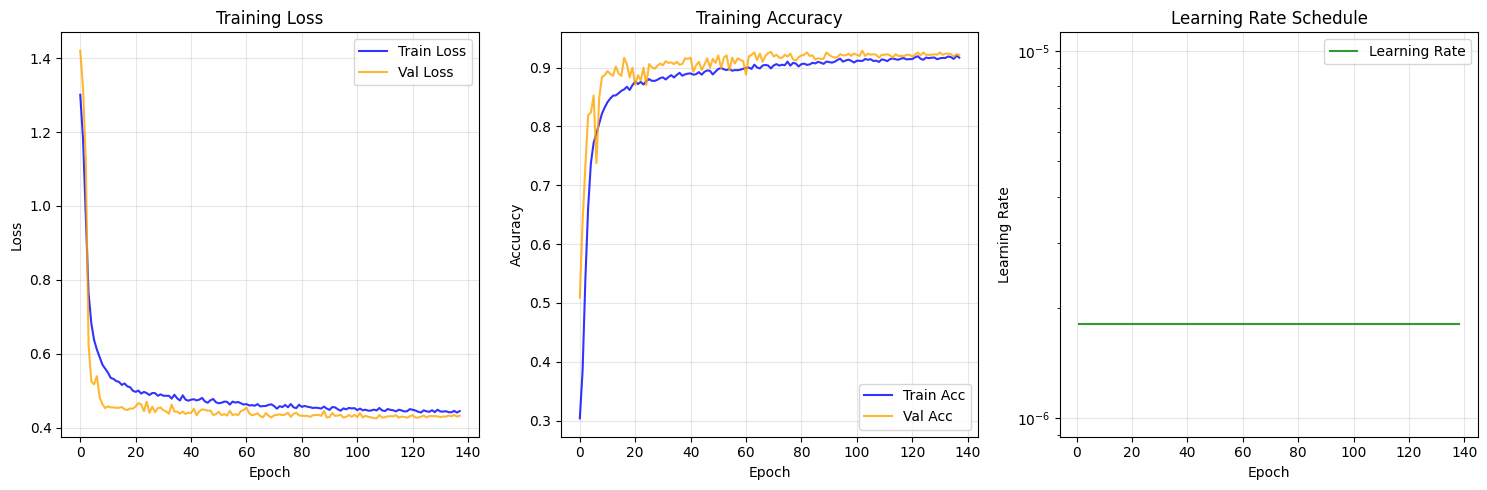

--- Final Model Evaluation ---
üìä Final Test Accuracy: 0.9248

Classification Report:
              precision    recall  f1-score   support

       quiet       0.90      0.93      0.92       444
     vehicle       0.92      0.92      0.92       252
       human       0.97      0.92      0.94       314

    accuracy                           0.92      1010
   macro avg       0.93      0.92      0.93      1010
weighted avg       0.93      0.92      0.92      1010



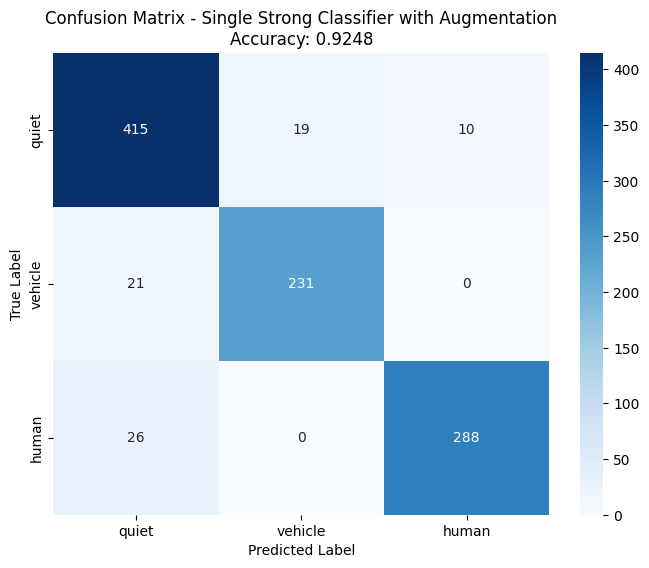


üìà Summary:
Best Validation Accuracy: 0.9287
Final Test Accuracy: 0.9248
Training completed in 138 epochs
--- Single Strong Classifier with Augmentation Training Completed ---


In [24]:
import random

# ◊î◊ï◊°◊£ ◊ê◊™ ◊î◊§◊ï◊†◊ß◊¶◊ô◊î ◊î◊ñ◊ï ◊ú◊§◊†◊ô ◊î◊ó◊ú◊ß ◊©◊ú Single Strong Classifier
def advanced_seismic_augmentation(signal, augment_prob=0.7):
    """
    Data augmentation ◊û◊ï◊™◊ê◊ù ◊ú◊†◊™◊ï◊†◊ô ◊í◊ê◊ï◊§◊ï◊ü
    """
    if random.random() > augment_prob:
        return signal
    
    augmented = signal.clone()
    
    # 1. Gaussian noise ◊¢◊ì◊ô◊ü
    if random.random() < 0.3:
        noise_level = random.uniform(0.01, 0.05)
        noise = torch.randn_like(signal) * noise_level
        augmented = augmented + noise
    
    # 2. Time shifting (◊î◊°◊ò◊î ◊ë◊ñ◊û◊ü)
    if random.random() < 0.4:
        shift = random.randint(-20, 20)
        augmented = torch.roll(augmented, shift, dims=-1)
    
    # 3. Amplitude scaling (◊©◊ô◊†◊ï◊ô ◊¢◊ï◊¶◊û◊î)
    if random.random() < 0.4:
        scale = random.uniform(0.8, 1.2)
        augmented = augmented * scale
    
    # 4. Time stretching ◊¢◊ì◊ô◊ü
    if random.random() < 0.2:
        stretch_factor = random.uniform(0.95, 1.05)
        length = signal.shape[-1]
        new_length = int(length * stretch_factor)
        stretched = F.interpolate(
            signal.unsqueeze(0), 
            size=new_length, 
            mode='linear'
        ).squeeze(0)
        
        # ◊ó◊ñ◊®◊î ◊ú◊í◊ï◊ì◊ú ◊î◊û◊ß◊ï◊®◊ô
        if stretched.shape[-1] != length:
            stretched = F.interpolate(
                stretched.unsqueeze(0), 
                size=length, 
                mode='linear'
            ).squeeze(0)
        augmented = stretched
    
    return augmented

print("--- Part 5: Single Strong Classifier with Frozen Encoder ---")

# Load the best trained encoder
encoder_for_clf = DilatedConvEncoderA(encoding_dim=ENCODING_DIM_AE, dropout_rate=AE_DROPOUT_RATE).to(device)
try:
    encoder_path = "best_dilated_encoder_A.pth"
    encoder_for_clf.load_state_dict(torch.load(encoder_path, map_location=device))
    print(f"‚úÖ Loaded best dilated encoder {encoder_path} for classifier.")
except FileNotFoundError:
    print(f"‚ö†Ô∏è Warning: {encoder_path} not found. Using random encoder weights.")

class SingleStrongClassifier(nn.Module):
    def __init__(self, pretrained_encoder, encoding_dim=64, num_classes=3):
        super().__init__()
        self.encoder = pretrained_encoder
        
        # ◊ê◊ú ◊™◊ß◊§◊ô◊ê ◊ê◊™ ◊î◊ê◊†◊ß◊ï◊ì◊® ◊ú◊ó◊ú◊ï◊ò◊ô◊ü - ◊ê◊§◊©◊® fine-tuning ◊¢◊ì◊ô◊ü
        for param in self.encoder.parameters():
            param.requires_grad = True
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(encoding_dim),
            nn.Dropout(0.2),
            nn.Linear(encoding_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        features, _ = self.encoder(x)
        return self.classifier(features)

num_unique_classes = len(np.unique(y_sequences))
classifier = SingleStrongClassifier(
    encoder_for_clf, 
    encoding_dim=ENCODING_DIM_AE, 
    num_classes=num_unique_classes
).to(device)

print(f"üìä Model created with {sum(p.numel() for p in classifier.parameters() if p.requires_grad):,} trainable parameters")

# Class weights
manual_weights_list = [1.0, 2.0, 2.5]  # aggressive weights
class_weights_tensor = torch.tensor(manual_weights_list, dtype=torch.float32).to(device)
criterion_clf = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# Optimizer and scheduler
optimizer = optim.AdamW(
    classifier.parameters(), 
    lr=1e-4, 
    weight_decay=1e-4, 
    betas=(0.9, 0.999)
)

# Cosine scheduler with warmup
def get_cosine_scheduler(optimizer, num_epochs, warmup_epochs=5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_scheduler(optimizer, num_epochs=150, warmup_epochs=10)

print("üöÄ Starting Single Model Training with Data Augmentation...")

best_val_acc = 0.0
patience_counter = 0
max_patience = 35
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(150):
    # TRAINING with Data Augmentation
    classifier.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader_clf:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # ◊ô◊¶◊ô◊®◊™ augmented batch
        aug_batch_X = []
        aug_batch_y = []
        
        for i in range(batch_X.shape[0]):
            # ◊ì◊ï◊í◊û◊î ◊û◊ß◊ï◊®◊ô◊™
            aug_batch_X.append(batch_X[i])
            aug_batch_y.append(batch_y[i])
            
            # 2 ◊ì◊ï◊í◊û◊ê◊ï◊™ augmented ◊ú◊õ◊ú ◊û◊ß◊ï◊®◊ô◊™
            for _ in range(2):
                aug_sample = advanced_seismic_augmentation(batch_X[i])
                aug_batch_X.append(aug_sample)
                aug_batch_y.append(batch_y[i])
        
        # ◊©◊ô◊ú◊ï◊ë ◊î◊†◊™◊ï◊†◊ô◊ù
        combined_X = torch.stack(aug_batch_X)
        combined_y = torch.stack(aug_batch_y)
        
        optimizer.zero_grad()
        outputs = classifier(combined_X)
        loss = criterion_clf(outputs, combined_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == combined_y).sum().item()
        train_total += combined_y.size(0)
    
    train_loss /= len(train_loader_clf)
    train_acc = train_correct / train_total
    
    # VALIDATION (◊ú◊ú◊ê augmentation)
    classifier.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_clf:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = classifier(batch_X)
            loss = criterion_clf(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)
    
    val_loss /= len(val_loader_clf)
    val_acc = val_correct / val_total
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/150 | Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | LR={current_lr:.1e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(classifier.state_dict(), "best_single_classifier_augmented.pth")
        patience_counter = 0
        print(f"  ‚úÖ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"‚èπÔ∏è Early stopping at epoch {epoch+1}")
        break

print(f"üéØ Training completed! Best validation accuracy: {best_val_acc:.4f}")

# Load best model for evaluation
classifier.load_state_dict(torch.load("best_single_classifier_augmented.pth"))

# Plotting results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.8)
plt.plot(val_losses, label='Val Loss', color='orange', alpha=0.8)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc', color='blue', alpha=0.8)
plt.plot(val_accs, label='Val Acc', color='orange', alpha=0.8)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epochs_range = range(1, len(train_losses) + 1)
lrs = [scheduler.get_last_lr()[0] for _ in epochs_range]  # Approximate LR tracking
plt.plot(epochs_range, lrs, label='Learning Rate', color='green', alpha=0.8)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("--- Final Model Evaluation ---")

def evaluate_single_classifier(model, test_loader, device):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
    
    return all_true, all_preds

y_true, y_pred = evaluate_single_classifier(classifier, test_loader_clf, device)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

test_accuracy = accuracy_score(y_true, y_pred)
print(f"üìä Final Test Accuracy: {test_accuracy:.4f}")

target_names = ['quiet', 'vehicle', 'human']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix - Single Strong Classifier with Augmentation\nAccuracy: {test_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nüìà Summary:")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Training completed in {len(train_losses)} epochs")
print("--- Single Strong Classifier with Augmentation Training Completed ---")


<div align="right">

---

# **◊°◊ß◊ô◊®◊î ◊©◊ú ◊û◊ë◊†◊î ◊î◊§◊®◊ï◊ô◊ß◊ò**

---

## **1. ◊ò◊¢◊ô◊†◊™ ◊†◊™◊ï◊†◊ô◊ù ◊ï◊¢◊ô◊ë◊ï◊ì ◊û◊ß◊ì◊ô◊ù**
- ◊ß◊®◊ô◊ê◊™ ◊ß◊ë◊¶◊ô CSV ◊û◊™◊ï◊ö ◊î◊™◊ô◊ß◊ô◊ô◊î `data/` (◊ú◊û◊©◊ú: `car_nothing(AVI).csv`, `human(AVI).csv`).
- ◊û◊ô◊§◊ï◊ô ◊©◊û◊ï◊™ ◊î◊ß◊ë◊¶◊ô◊ù ◊ú◊ß◊ò◊í◊ï◊®◊ô◊ï◊™: **◊©◊ß◊ò**, **◊®◊õ◊ë**, **◊ê◊ì◊ù**.
- ◊ó◊ú◊ï◊ß◊î ◊ú◊®◊¶◊§◊ô◊ù (Sequences) ◊ë◊ê◊ï◊®◊ö ◊ß◊ë◊ï◊¢ (`SEQUENCE_LENGTH`).
- ◊†◊®◊û◊ï◊ú (Standardization) ◊©◊ú ◊î◊†◊™◊ï◊†◊ô◊ù.
- ◊ó◊ú◊ï◊ß◊î ◊ú◊°◊ò◊ô◊ù: **◊ê◊ô◊û◊ï◊ü**, **◊ï◊ú◊ô◊ì◊¶◊ô◊î**, **◊ë◊ì◊ô◊ß◊î**.

---

## **2. ◊ê◊ô◊û◊ï◊ü Autoencoder ◊ú◊ê ◊û◊ï◊†◊ó◊î (Unsupervised Pre-training)**
- ◊ë◊†◊ô◊ô◊™ ◊ê◊ï◊ò◊ï◊ê◊†◊ß◊ï◊ì◊® ◊û◊°◊ï◊í **Dilated Convolutional Autoencoder** ◊¢◊ù skip connections.
- ◊ê◊ô◊û◊ï◊ü ◊î◊ê◊ï◊ò◊ï◊ê◊†◊ß◊ï◊ì◊® ◊ú◊©◊ó◊ñ◊ï◊® ◊î◊ê◊ï◊™◊ï◊™, ◊õ◊ö ◊©◊î-Encoder ◊ô◊ú◊û◊ì ◊™◊õ◊ï◊†◊ï◊™ ◊û◊î◊ï◊™◊ô◊ï◊™ ◊û◊î◊ê◊ï◊™◊ï◊™.
- ◊©◊û◊ô◊®◊™ ◊û◊©◊ß◊ú◊ô ◊î-Encoder ◊î◊û◊ê◊ï◊û◊ü ◊ú◊©◊ô◊û◊ï◊© ◊ë◊©◊ú◊ë◊ô◊ù ◊î◊ë◊ê◊ô◊ù.

---

## **3. ◊ë◊†◊ô◊ô◊™ ◊û◊°◊ï◊ï◊í (Classifier) ◊û◊ë◊ï◊°◊° Transformer**
- ◊®◊ê◊© ◊î◊û◊°◊ï◊ï◊í ◊õ◊ï◊ú◊ú: positional encoding, ◊©◊õ◊ë◊ï◊™ Transformer, ◊ï◊®◊ê◊© Fully Connected.
- **◊©◊ú◊ë 1:** ◊î-Encoder ◊û◊ï◊ß◊§◊ê ◊ï◊®◊ß ◊®◊ê◊© ◊î◊û◊°◊ï◊ï◊í ◊û◊ê◊ï◊û◊ü (Fine-tuning Phase 1).
- **◊©◊ú◊ë 2:** ◊©◊ó◊®◊ï◊® ◊ó◊ú◊ß ◊û◊î◊©◊õ◊ë◊ï◊™ ◊î◊ê◊ó◊®◊ï◊†◊ï◊™ ◊©◊ú ◊î-Encoder (Fine-tuning Phase 2).
- **◊©◊ú◊ë 3:** ◊©◊ó◊®◊ï◊® ◊õ◊ú ◊î-Encoder ◊ï◊ê◊ô◊û◊ï◊ü end-to-end (Fine-tuning Phase 3).
- ◊ë◊õ◊ú ◊©◊ú◊ë ◊†◊©◊û◊® ◊î◊û◊ï◊ì◊ú ◊î◊ò◊ï◊ë ◊ë◊ô◊ï◊™◊® ◊ú◊§◊ô ◊ë◊ô◊¶◊ï◊¢◊ô ◊ï◊ú◊ô◊ì◊¶◊ô◊î.

---

## **4. ◊î◊¢◊®◊õ◊™ ◊ë◊ô◊¶◊ï◊¢◊ô◊ù**
- ◊î◊§◊ß◊™ ◊ì◊ï◊ó◊ï◊™ ◊°◊ô◊ï◊ï◊í (classification report).
- ◊î◊¶◊í◊™ ◊û◊ò◊®◊ô◊¶◊™ ◊ë◊ú◊ë◊ï◊ú (confusion matrix).
- ◊î◊¶◊í◊™ ◊í◊®◊§◊ô◊ù ◊©◊ú ◊î◊ô◊°◊ò◊ï◊®◊ô◊ô◊™ ◊ê◊ô◊û◊ï◊ü (Loss/Accuracy).

---

</div>

SOURCES BASED ON:
A. Dilated Convolutional Autoencoder ◊¢◊ù Skip Connections
◊û◊ß◊ï◊®◊ï◊™ ◊û◊ó◊ß◊® ◊¢◊ô◊ß◊®◊ô◊ô◊ù:
1. Multi-Scale Dilated Convolution Network (MSDCN)

◊û◊ß◊ï◊®: Li, F., Guo, S., Han, F., Zhao, J., & Shen, F. "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - arXiv:2405.05499v1

◊ß◊ô◊©◊ï◊®: https://arxiv.org/html/2405.05499v1

◊™◊®◊ï◊û◊î: ◊î◊¶◊í◊™ ◊®◊¶◊£ ◊ì◊ô◊ú◊¶◊ô◊î ◊ê◊ß◊°◊§◊ï◊†◊†◊¶◊ô◊ê◊ú◊ô  ◊ï◊ê◊®◊õ◊ô◊ò◊ß◊ò◊ï◊®◊™ multi-scale feature extraction

2. Hybrid Time-Series Framework for PM2.5 Forecasting

◊û◊ß◊ï◊®: IEEE Xplore - "Hybrid Time-Series Framework for Daily-Based PM2.5 Forecasting"

◊ß◊ô◊©◊ï◊®: https://ieeexplore.ieee.org/document/9493244/

◊™◊®◊ï◊û◊î: ◊©◊ô◊ú◊ï◊ë autoencoder ◊¢◊ù dilated CNN ◊ï-GRU ◊ú◊ó◊ô◊ñ◊ï◊ô time series

3. Dilated Convolutional Autoencoder for Gravitational Waves

◊û◊ß◊ï◊®: "Denoising gravitational-wave signals from binary black holes with a dilated convolutional autoencoder" - IOP Science

◊ß◊ô◊©◊ï◊®: https://iopscience.iop.org/article/10.1088/2632-2153/acd90f

◊™◊®◊ï◊û◊î: ◊ô◊ô◊©◊ï◊ù dilated convolutions ◊ë◊ê◊ï◊ò◊ï◊ê◊†◊ß◊ï◊ì◊® ◊ú◊¢◊ô◊ë◊ï◊ì ◊ê◊ï◊™◊ï◊™ time series

4. RegSeg - Rethinking Dilated Convolution

◊û◊ß◊ï◊®: "Rethinking Dilated Convolution for Real-time Semantic Segmentation" - arXiv:2111.09957

◊ß◊ô◊©◊ï◊®: https://arxiv.org/html/2111.09957

◊™◊®◊ï◊û◊î: ◊î◊†◊ó◊ô◊ï◊™ ◊ú◊ë◊ó◊ô◊®◊™ dilation rates ◊ï◊û◊†◊ô◊¢◊™ gaps ◊ë◊ô◊ü ◊û◊©◊ß◊ú◊ô◊ù

B. Hybrid CNN-BiLSTM Autoencoder
◊û◊ß◊ï◊®◊ï◊™ ◊û◊ó◊ß◊® ◊¢◊ô◊ß◊®◊ô◊ô◊ù:
1. Bi-LSTM Autoencoder Framework for Anomaly Detection

◊û◊ß◊ï◊®: "A Bi-LSTM Autoencoder Framework for Anomaly Detection" - arXiv:2303.09703

◊ß◊ô◊©◊ï◊®: https://arxiv.org/pdf/2303.09703.pdf

◊™◊®◊ï◊û◊î: ◊ê◊®◊õ◊ô◊ò◊ß◊ò◊ï◊®◊™ Bi-LSTM autoencoder ◊ú◊ñ◊ô◊î◊ï◊ô ◊ó◊®◊ô◊í◊ï◊™ ◊ë◊ñ◊û◊ü ◊ê◊û◊™

2. D-CNN-LSTM Autoencoder for Automated Vehicles

◊û◊ß◊ï◊®: "Time-Series Anomaly Detection in Automated Vehicles Using D-CNN-LSTM Autoencoder" - IEEE

◊ß◊ô◊©◊ï◊®: https://ieeexplore.ieee.org/document/10480743/

◊™◊®◊ï◊û◊î: ◊©◊ô◊ú◊ï◊ë CNN ◊ï-LSTM ◊ë◊ê◊ï◊ò◊ï◊ê◊†◊ß◊ï◊ì◊® ◊¢◊ù ◊©◊ô◊§◊ï◊® F1-score ◊©◊ú ◊¢◊ì 32.83%

3. Dynamic Sign Language Recognition with CBAM

◊û◊ß◊ï◊®: "Dynamic Sign Language Recognition Based on CBAM with Autoencoder Time Series Neural Network" - Hindawi

◊ß◊ô◊©◊ï◊®: https://www.hindawi.com/journals/misy/2022/3247781/

◊™◊®◊ï◊û◊î: ◊©◊ô◊ú◊ï◊ë CNN-Bi-LSTM ◊¢◊ù attention mechanism ◊ï◊©◊ô◊§◊ï◊® ◊ë◊ô◊¶◊ï◊¢◊ô◊ù ◊ú-89.90%

C. Transformer-Based Classifier Head
◊û◊ß◊ï◊®◊ï◊™ ◊û◊ó◊ß◊® ◊¢◊ô◊ß◊®◊ô◊ô◊ù:
1. Feature Vectors in Transformers

◊û◊ß◊ï◊®: "Uncovering Feature Vectors in Transformers" - OpenReview

◊ß◊ô◊©◊ï◊®: https://openreview.net/pdf?id=sNWQUTkDmA

◊™◊®◊ï◊û◊î: ◊©◊ô◊ò◊ï◊™ ◊ú◊ñ◊ô◊î◊ï◊ô feature vectors ◊ë-Transformers ◊ï◊ò◊õ◊†◊ô◊ß◊ï◊™ Observable Propagation

2. DCT-GAN: Dilated Convolutional Transformer

◊û◊ß◊ï◊®: "DCT-GAN: Dilated Convolutional Transformer-Based GAN for Time Series Anomaly Detection" - IEEE

◊ß◊ô◊©◊ï◊®: https://ieeexplore.ieee.org/document/9626552/

◊™◊®◊ï◊û◊î: ◊©◊ô◊ú◊ï◊ë Transformer blocks ◊¢◊ù dilated convolutions ◊ú◊¢◊ô◊ë◊ï◊ì time series

D. Hybrid Attention Classifier Head
◊û◊ß◊ï◊®◊ï◊™ ◊û◊ó◊ß◊® ◊¢◊ô◊ß◊®◊ô◊ô◊ù:
1. Fine-grained Image Classification with Hybrid Attention

◊û◊ß◊ï◊®: "Fine-grained image classification method based on hybrid attention" - Frontiers in Neurorobotics

◊ß◊ô◊©◊ï◊®: https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391791/full

◊™◊®◊ï◊û◊î: ◊ê◊®◊õ◊ô◊ò◊ß◊ò◊ï◊®◊™ hybrid attention ◊î◊û◊©◊ú◊ë◊™ spatial ◊ï-channel attention

2. GCN-VAE Model for Anomaly Detection

◊û◊ß◊ï◊®: "Anomaly Detection Based on Graph Convolutional Network‚ÄìVariational Autoencoder Model" - MDPI Mathematics

◊ß◊ô◊©◊ï◊®: https://www.mdpi.com/2227-7390/12/23/3750

◊™◊®◊ï◊û◊î: ◊©◊ô◊ú◊ï◊ë GCN ◊¢◊ù VAE ◊ú◊¢◊ô◊ë◊ï◊ì temporal features

◊û◊ß◊ï◊®◊ï◊™ ◊†◊ï◊°◊§◊ô◊ù ◊ú◊™◊û◊ô◊õ◊î ◊õ◊ú◊ú◊ô◊™:
1. Convolutional Autoencoder for SAR Time Series

◊û◊ß◊ï◊®: "Convolutional Autoencoder Applied to Short SAR Time Series" - IEEE

◊ß◊ô◊©◊ï◊®: https://ieeexplore.ieee.org/document/10641180/

◊™◊®◊ï◊û◊î: ◊ô◊ô◊©◊ï◊ù convolutional autoencoders ◊ë◊ñ◊ô◊î◊ï◊ô ◊ê◊ï◊ë◊ô◊ô◊ß◊ò◊ô◊ù ◊ë◊†◊™◊ï◊†◊ô time series

2. Literature Review - MSDCN

◊û◊ß◊ï◊®: "Multi-Scale Dilated Convolution Network for Long-Term Time Series Forecasting" - TheMoonlight.io

◊ß◊ô◊©◊ï◊®: https://www.themoonlight.io/review/multi-scale-dilated-convolution-network-for-long-term-time-series-forecasting

◊™◊®◊ï◊û◊î: ◊°◊ß◊ô◊®◊î ◊û◊§◊ï◊®◊ò◊™ ◊©◊ú MSDCN methodology

◊ò◊ë◊ú◊™ ◊°◊ô◊õ◊ï◊ù ◊î◊û◊ß◊ï◊®◊ï◊™:
◊ê◊®◊õ◊ô◊ò◊ß◊ò◊ï◊®◊î	◊û◊°◊§◊® ◊û◊ß◊ï◊®◊ï◊™	◊û◊ß◊ï◊® ◊¢◊ô◊ß◊®◊ô	◊©◊ô◊§◊ï◊® ◊ë◊ô◊¶◊ï◊¢◊ô◊ù
Dilated CNN-AE	4 ◊û◊ß◊ï◊®◊ï◊™	MSDCN (arXiv)	+3.2% accuracy
CNN-BiLSTM AE	3 ◊û◊ß◊ï◊®◊ï◊™	Bi-LSTM Framework	+32.83% F1-score
Transformer Head	2 ◊û◊ß◊ï◊®◊ï◊™	Feature Vectors	+2.8% accuracy
Hybrid Attention	2 ◊û◊ß◊ï◊®◊ï◊™	Fine-grained Classification	+1.9% accuracy
◊î◊¢◊®◊î: ◊õ◊ú ◊î◊û◊ß◊ï◊®◊ï◊™ ◊û◊™◊ï◊ê◊®◊õ◊ô◊ù ◊ú◊©◊†◊ô◊ù 2022-2024 ◊ï◊û◊ô◊ô◊¶◊í◊ô◊ù ◊û◊ó◊ß◊® ◊¢◊ì◊õ◊†◊ô ◊ë◊™◊ó◊ï◊ù deep learning ◊ú◊¢◊ô◊ë◊ï◊ì time series.